In [1]:
import time
import matplotlib.pyplot as plt, matplotlib.animation
import numpy as np
import numba as nb
from numba import types

In [2]:
###############################################################################
## LBM settings
###############################################################################

# D2Q9
D = 2 # dimensions
Q = 9 # pattern

V = np.array([
    [-1, 1],[ 0, 1],[ 1, 1],
    [-1, 0],[ 0, 0],[ 1, 0],
    [-1,-1],[ 0,-1],[ 1,-1]
])

W = np.array([
    1/36, 1/9, 1/36,
    1/9,  4/9, 1/9,
    1/36, 1/9, 1/36
])

C = 1/3**0.5  # Speed of sound 

In [3]:
###############################################################################
## rewrite np.roll for numba
###############################################################################


@nb.njit(parallel=True)
# roll for 2d arrays
def numba_roll(a, shf, axis):
    b = np.empty_like(a)
    
    # row shifts
    if axis == 1:  
        rows_num = a.shape[0]
        cols_num = a.shape[1]
        if shf < 0:
            shf = cols_num + shf 
            
        for i in nb.prange(rows_num):
            b[i, shf:] = a[i, :cols_num - shf]
            b[i, :shf] = a[i, cols_num - shf:]
    
    # cols shift
    elif axis == 0:
        rows_num = a.shape[0]
        cols_num = a.shape[1]
        if shf < 0:
            shf = rows_num + shf
        for j in nb.prange(cols_num):
            b[shf:, j] = a[:rows_num - shf, j]
            b[:shf, j] = a[rows_num - shf:, j]
    
    return b

# unit-testing
def roll_test():
    test = np.arange(12).reshape(3, 4)

    for axis in [0, 1]:
        for shift in [-1, 0, 1]:
            assert(np.all(np.roll(test, shift, axis) == numba_roll(test, shift, axis)))

roll_test()

###############################################################################
## rewrite 2d arrays updating with boolean indexing
###############################################################################

@nb.njit()
def update_arrays(f1, f2, barrier1, barrier2):
    indices1 = np.argwhere(barrier1)
    indices2 = np.argwhere(barrier2)
    
    # Проверяем, чтобы количество элементов совпадало
    min_len = min(len(indices1), len(indices2))
    
    for k in range(min_len):
        i1, j1 = indices1[k]
        i2, j2 = indices2[k]
        f1[i1, j1] = f2[i2, j2]

In [4]:
###############################################################################
## Barrier creation
###############################################################################

@nb.njit(parallel=True)
def BarrierShape():
    """ Инициализируем форму барьера. Необходимо установить True там, где барьер """
    barrier = np.zeros((Height, Width), types.bool_)

    # circle
    for y in range(barrier.shape[0]):
        for x in range(barrier.shape[1]):
            if (y - Height//2)**2 + (x - Height//2)**2 < (Height//10)**2:
                barrier[y,x] = True
    return barrier

@nb.njit()
def InitBarrier():
    """ Создаем барьер и отталкивающие границы барьера """
    barrierC = BarrierShape()

    barrierN = numba_roll(barrierC,  1, 0)
    barrierS = numba_roll(barrierC, -1, 0)
    barrierE = numba_roll(barrierC,  1, 1)
    barrierW = numba_roll(barrierC, -1, 1)
    barrierNE = numba_roll(barrierN,  1, 1)
    barrierNW = numba_roll(barrierN, -1, 1)
    barrierSE = numba_roll(barrierS,  1, 1)
    barrierSW = numba_roll(barrierS, -1, 1)

    result = np.empty((9,) + barrierC.shape, dtype=barrierC.dtype)
    result[0] = barrierNW
    result[1] = barrierN
    result[2] = barrierNE
    result[3] = barrierW
    result[4] = barrierC
    result[5] = barrierE
    result[6] = barrierSW
    result[7] = barrierS
    result[8] = barrierSE

    return result

In [5]:
###############################################################################
## LBM with Bhatnagar–Gross–Krook
###############################################################################

@nb.njit(parallel=True)
def F_stat(Ux, Uy, Rho):
    """ Вычисляем статистическое распределение частиц в зависимости от общей скорости и плотности """
    UV = np.zeros((Q, Height, Width)) 
    for q in range(Q):
        UV[q] = (V[q,0]*Ux + V[q,1]*Uy)/C**2

    U2 = (Ux**2 + Uy**2)/C**2

    f_stat = np.zeros((Q, Height, Width))
    for q in range(Q):
        f_stat[q] = Rho * W[q] * (1 + UV[q] + UV[q]**2/2 - U2/2)

    return f_stat

@nb.njit(parallel=True)
def Mode0(f):
    mode = np.zeros((Height, Width))
    for q in range(Q):
        mode += f[q]
    return mode

@nb.njit(parallel=True)
def Mode1(f):
    """ Плотность*Скорость """
    mode = np.zeros((D, Height, Width))
    for q in range(Q):
        for d1 in range(D):
            mode[d1] += f[q]*V[q,d1]
    return mode
    
@nb.njit(parallel=True)
def Mode2(f):
    """ Плотность*[Скорость x Скорость] минус тензор напряжения """
    mode = np.zeros((D,D,Height, Width))
    for q in range(Q):
        for d1 in range(D):
            for d2 in range(D):
                mode[d1,d2] += f[q]*V[q,d1]*V[q,d2]
    return mode

In [6]:
###############################################################################
## curl operator with numba roll
###############################################################################

@nb.njit(parallel=True)
def curl(ux, uy):
    """ двумерный ротор макроскопического поля скорости """ 
    return numba_roll(uy, -1, 1) - numba_roll(uy, 1, 1) - numba_roll(ux, -1, 0) + numba_roll(ux, 1, 0)

In [7]:
###############################################################################
## iteration
###############################################################################

@nb.njit()
def iter(f, f_out, barrier):
    """stream"""   

    (fNW, fN, fNE, fW, fC, fE, fSW, fS, fSE) = f

    for y in range(Height-1,0,-1):
        fN[y]  = fN[y-1]
        fNE[y] = fNE[y-1]
        fNW[y] = fNW[y-1]

    fS[:-1]  = fS[1:]
    fSE[:-1] = fSE[1:]
    fSW[:-1] = fSW[1:]

    fE[:,1:]  = fE[:,:-1]
    fNE[:,1:] = fNE[:,:-1]
    fSE[:,1:] = fSE[:,:-1]

    fW[:,:-1]  = fW[:,1:]
    fNW[:,:-1] = fNW[:,1:]
    fSW[:,:-1] = fSW[:,1:]

    (bNW, bN, bNE, bW, bC, bE, bSW, bS, bSE) = barrier
    
    update_arrays(fN, fS, bN, bC)
    update_arrays(fS, fN, bS, bC)
    update_arrays(fE, fW, bE, bC)
    update_arrays(fW, fE, bW, bC)
    
    update_arrays(fNE, fSW, bNE, bC)
    update_arrays(fNW, fSE, bNW, bC)
    update_arrays(fSE, fNW, bSE, bC)
    update_arrays(fSW, fNE, bSW, bC)

    """ Calc U, Rho """
    Rho = Mode0(f)

    Ux, Uy = Mode1(f)
    Ux /= Rho
    Uy /= Rho

    """ Collide """

    f += (F_stat(Ux, Uy, Rho)-f)/(0.5 + Viscosity/C**2)

    """ BC_out """

    f[:,0,:] = f_out[:,0,:]
    f[:,-1,:] = f_out[:,-1,:]
    f[:,:,0] = f_out[:,:,0]
    f[:,:,-1] = f_out[:,:,-1]

In [8]:
def main():
    global Viscosity, Height, Width, U0, Ux, Uy, Rho, Ux0, Uy0, Rho0
    Viscosity = 0.01                                # вязкость жидкости
    Height, Width = 80, 200                       # размеры решетки
    
    U0 = np.array([0.15, 0])                        # начальная и внешняя скорость (в махах)
    
    Ux  = np.zeros((Height, Width)) + U0[0]
    Uy  = np.zeros((Height, Width)) + U0[1]
    Rho = np.ones((Height, Width))
    
    Ux0  = np.zeros((Height, Width)) + U0[0]
    Uy0  = np.zeros((Height, Width)) + U0[1]
    Rho0 = np.ones((Height, Width))
    barrier = InitBarrier()
    
    F = F_stat(Ux, Uy, Rho)
    
    F_out = F_stat(Ux, Uy, Rho)
    for _ in range(40):
        now = time.time()
        iter(F, F_out, barrier)
        print(time.time() - now)
        Rho = Mode0(F)
        Ux, Uy = Mode1(F)
        
        # E = Mode2(F)
        Ux /= Rho
        Uy /= Rho
    
    fig, ax = plt.subplots()
    
    fluidImage = ax.imshow(curl(Ux, Uy), origin='lower', norm=plt.Normalize(-.1,.1), cmap=plt.get_cmap('jet'), interpolation='none')
    
    bImageArray = np.zeros((Height, Width, 4), np.uint8)
    bImageArray[barrier[4],3] = 100
    barrierImage = plt.imshow(bImageArray, origin='lower', interpolation='none')
    
    def nextFrame(_):
        for _ in range(40):
            iter(F, F_out, barrier)
    
        Rho = Mode0(F)
        Ux, Uy = Mode1(F)
        Ux /= Rho
        Uy /= Rho
    
        fluidImage.set_array(curl(Ux, Uy))
        return (fluidImage, barrierImage)        
    
    animate = matplotlib.animation.FuncAnimation(fig, nextFrame, frames = 500, interval=1, blit=True)
    animate.save("numba.mp4", fps = 10)
    plt.show()

14.599506378173828
0.0040242671966552734
0.004003286361694336
0.003000020980834961
0.003523111343383789
0.0029997825622558594
0.0035080909729003906
0.0030820369720458984
0.003509044647216797
0.003003835678100586
0.0029997825622558594
0.0030121803283691406
0.004004478454589844
0.003999948501586914
0.0030257701873779297
0.003999948501586914
0.00401759147644043
0.003000497817993164
0.0035054683685302734
0.0035135746002197266
0.0029985904693603516
0.0035474300384521484
0.0030002593994140625
0.0035088062286376953
0.003009796142578125
0.004000663757324219
0.003007173538208008
0.003008127212524414
0.0029997825622558594
0.0030121803283691406
0.0030007362365722656
0.003005504608154297
0.0029296875
0.003000020980834961
0.0030126571655273438
0.0030448436737060547
0.003005504608154297
0.0029997825622558594
0.0030002593994140625
0.0030193328857421875


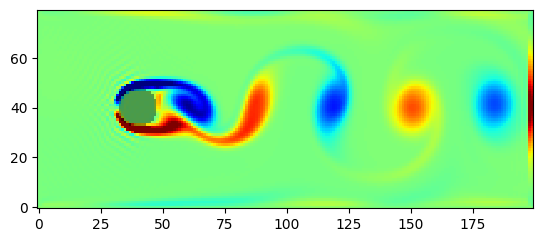

In [9]:
main()